<h1 align=center><font size = 5>Clustering Paris Neighborhoods</font></h1>

## Introduction

In this notebook, we will analyze and cluster Paris Neighborhoods.

## Table of Contents

1. <a href="#item1">Installing and Importing of Libraries</a>
2. <a href="#item2">Scraping and Cleaning Toronto Neighborhood Data</a>  
3. <a href="#item3">Exploration of Location Data</a>  
4. <a href="#item4">Get Venues Data from Foursquare</a>
5. <a href="#item5">Analyze Neighborhoods</a>
6. <a href="#item6">Explore neighbourhoods with data visualization</a>
7. <a href="#item6">Cluster Neighborhoods</a>

<a id="item1"></a>

## 1. Installing and Importing of Libraries

In [1]:
try:
    print("Installing ProgressBar...\n")
    !pip install ProgressBar2
    print("ProgressBar has been successfully installed!\n")
except:
    print("ERROR: could not install ProgressBar!\n")

try:
    print("Installing Folium...\n")
    !pip install folium
    print("Folium has been successfully installed!\n")
except:
    print("ERROR: could not install Folium!\n")

try:
    print("Importing libraries...\n")
    #from progressbar import ProgressBar
    from bs4 import BeautifulSoup as bts # library for web scraping
    import numpy as np # library to handle data in a vectorized manner
    import pandas as pd # library for data analysis
    from pandas.io.json import json_normalize
    import matplotlib as mp # library for visualization
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    import requests # library to handle requests
    import json
    from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
    from sklearn.cluster import KMeans # import k-means from clustering stage
    from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
    import os
    import folium # map rendering library
    import lxml
    import re
    import types
    from botocore.client import Config
    import ibm_boto3
    from time import sleep
    print("All libraries imported successfully!\n")
except:
    print("ERROR: Could not import all libraries!\n")

%matplotlib inline

Installing ProgressBar...

ProgressBar has been successfully installed!

Installing Folium...

Folium has been successfully installed!

Importing libraries...

All libraries imported successfully!



<a id="item2"></a>

## Scraping and Cleaning Paris Neighborhood Data

Let's get Paris neighborhoods data from opendata.paris.fr

In [2]:
url_paris_data = 'https://opendata.paris.fr/api/records/1.0/search/?dataset=quartier_paris&rows=100&facet=l_qu&facet=c_ar'

results = json.loads(requests.get(url_paris_data).text)

We create 2 data dictionnaries:
    - neighbourhoods_geo : to create a GeoJSON file representing the Paris neighbourhoods in the map
    - neighbourhoods : to create a Dataframe to store Paris neighbourhoods data

In [3]:
neighbourhoods_geo = []
neighbourhoods = []

for record in results['records']:
    neighbourhood_geo = {'type': 'Feature'}
    neighbourhood = {}
    properties = {}
    
    neighbourhood['Latitude'] = record['geometry']['coordinates'][1]
    neighbourhood['Longitude'] = record['geometry']['coordinates'][0]
    
    for key, val in record['fields'].items():
        if key == 'l_qu':
            properties['name'] = val
            neighbourhood['Name'] = val
        elif key == 'geom':
            neighbourhood_geo['geometry'] = val
        elif key == 'c_ar':
            neighbourhood['Borough'] = val
    
    neighbourhood_geo['properties'] = properties 
    neighbourhoods_geo.append(neighbourhood_geo)
    neighbourhoods.append(neighbourhood)

geo_json = {'type': 'FeatureCollection'}
geo_json['features'] = neighbourhoods_geo

neighbourhoods = json_normalize(neighbourhoods)

In [4]:
neighbourhoods.head()

,Borough,Latitude,Longitude,Name
0,2,48.867150,2.350080,Bonne-Nouvelle
1,3,48.863887,2.363123,Enfants-Rouges
2,4,48.858521,2.351667,Saint-Merri
3,4,48.855719,2.358162,Saint-Gervais
4,5,48.841940,2.356894,Jardin-des-Plantes


<a id="item3"></a>

We use another web site to get the Young Ratio. We define the Young Ratio as the percentage of people with age range between 20 and 39. We get data from the French Institute of Statistics and Economic Studies.

We define a function that we will call for each borough.

In [5]:
def getPopluationbyAges(boroughs):
    
    ratio_list=[]
    
    for borough in boroughs:
        
        if len(str(borough)) == 1:
            borough_number = '0' + str(borough)
        else:
            borough_number = borough
        # create the API request URL
        url = 'https://www.insee.fr/fr/statistiques/4177137?sommaire=4177572&geo=COM-751{}'.format(borough_number)
            
        # make the GET request
        results = requests.get(url)
        
        soup = bts(results.text, 'html.parser')     
        table = soup.find_all(id='produit-tableau-EMP1_V1_ENS_ENS')
        table_rows = table[0].find_all('tr')
        total_population = 1
        student_population = 1
        
        for tr in table_rows:
            
            age = tr.find_all('th')[0].text
            
            if age == '25 à 39 ans' or age == '20 à 24 ans':
                
                student_population += int(tr.find_all('td')[2].text.replace('\xa0',''))
            elif age == 'Ensemble':
                total_population = int(tr.find_all('td')[2].text.replace('\xa0',''))
        
        l = []
        l.append(borough)
        l.append(round(student_population/total_population,2))
        ratio_list.append(l)
    
    col = ['Borough','Young Ratio']
    young_ratio = pd.DataFrame(ratio_list, columns=col)
    
    return(young_ratio)

In [6]:
young_ratio = getPopluationbyAges(neighbourhoods['Borough'].unique().tolist())

We append the young ratio to the neighbourhoods dataframe

In [7]:
neighbourhoods = pd.merge(neighbourhoods, young_ratio, how='left', on=['Borough'])
neighbourhoods.head()

,Borough,Latitude,Longitude,Name,Young Ratio
0,2,48.867150,2.350080,Bonne-Nouvelle,0.52
1,3,48.863887,2.363123,Enfants-Rouges,0.48
2,4,48.858521,2.351667,Saint-Merri,0.41
3,4,48.855719,2.358162,Saint-Gervais,0.41
4,5,48.841940,2.356894,Jardin-des-Plantes,0.45


## Exploration of Location Data

Let's get the geographical coordinates of Paris.

In [8]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Paris are 48.8566101, 2.3514992.


In [9]:
# create a numpy array and has linear spacing 
threshold_scale = np.linspace(neighbourhoods['Borough'].min(),
                              neighbourhoods['Borough'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

In [10]:
m = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.Choropleth(
    geo_data=geo_json,
    data=neighbourhoods,
    columns=['Name', 'Borough'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlGn',
    legend_name='Paris neighbourhoods',
    fill_opacity=0.7, 
    line_opacity=0.2,
    reset = True
).add_to(m)

m

<a id="item4"></a>

## Get Venues Data from Foursquare

In [11]:
# The code was removed by Watson Studio for sharing.

### Get Categories

In [12]:
url_category = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)

In [13]:
results_category = requests.get(url_category).json()

In [14]:
categories = []

for category in results_category['response']['categories']:
    
    categories.append((category['name'], category['name'], '', ''))
    for sub_category in category['categories']:
        
        categories.append((sub_category['name'], category['name'], sub_category['name'], ''))
        for sub_sub_category in sub_category['categories']:
            
            categories.append((sub_sub_category['name'], category['name'], sub_category['name'], sub_sub_category['name']))

categories = pd.DataFrame(categories)
categories.columns = ['Category',
            'Level 1', 
            'Level 2', 
            'Level 3']

#categories_df.loc[categories_df['Level 2']=='',['Level 2']] = categories_df['Level 1']
#categories_df.loc[categories_df['Level 3']=='',['Level 3']] = categories_df['Level 2']

categories.head()

,Category,Level 1,Level 2,Level 3
0,Arts & Entertainment,Arts & Entertainment,,
1,Amphitheater,Arts & Entertainment,Amphitheater,
2,Aquarium,Arts & Entertainment,Aquarium,
3,Arcade,Arts & Entertainment,Arcade,
4,Art Gallery,Arts & Entertainment,Art Gallery,


### Get Venues from Foursquare

Let's create a function to repeat the same process to all the neighborhoods

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            400)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Venue', 
                  'Category']
    
    return(nearby_venues)

In [16]:
paris_venues = getNearbyVenues(names=neighbourhoods['Name'],
                                   latitudes=neighbourhoods['Latitude'],
                                   longitudes=neighbourhoods['Longitude']
                                  )

In [17]:
#paris_venues['Total Venues'] = paris_venues.groupby('Neighborhood')['Neighborhood'].transform('count')
paris_venues.head()

,Neighbourhood,Venue,Category
0,Bonne-Nouvelle,Ma Cave Fleury,Wine Shop
1,Bonne-Nouvelle,Les Amis des Messina,Italian Restaurant
2,Bonne-Nouvelle,Hoppy Corner,Beer Bar
3,Bonne-Nouvelle,Tealer,Boutique
4,Bonne-Nouvelle,Experimental Cocktail Club,Cocktail Bar


In [18]:
paris_venues = pd.merge(paris_venues, categories, how='left', on=['Category'])

Let's find out how many unique categories can be curated from all the returned venues

In [19]:
paris_venues.head()

,Neighbourhood,Venue,Category,Level 1,Level 2,Level 3
0,Bonne-Nouvelle,Ma Cave Fleury,Wine Shop,Shop & Service,Food & Drink Shop,Wine Shop
1,Bonne-Nouvelle,Les Amis des Messina,Italian Restaurant,Food,Italian Restaurant,
2,Bonne-Nouvelle,Hoppy Corner,Beer Bar,Nightlife Spot,Bar,Beer Bar
3,Bonne-Nouvelle,Tealer,Boutique,Shop & Service,Clothing Store,Boutique
4,Bonne-Nouvelle,Experimental Cocktail Club,Cocktail Bar,Nightlife Spot,Bar,Cocktail Bar


In [20]:
print('There are {} uniques categories.'.format(len(paris_venues['Level 1'].unique())))

There are 9 uniques categories.


<a id="item5"></a>

## Analyze Neighborhoods

In [21]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Level 1']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighbourhood'] = paris_venues['Neighbourhood'] 
#paris_onehot['Total Venues'] = paris_venues['Total Venues']

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

In [22]:
paris_grouped = paris_onehot.groupby('Neighbourhood').sum().reset_index()
paris_grouped.head()

,Neighbourhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Amérique,0,0,6,0,4,0,2,2
1,Archives,9,0,52,4,6,2,24,2
2,Arsenal,6,0,42,5,9,1,6,8
3,Arts-et-Métiers,7,0,61,14,1,0,9,6
4,Auteuil,3,0,1,0,9,1,1,0


In [23]:
paris_grouped['Total Venues'] = paris_grouped.sum(axis = 1, skipna = True)

In [24]:
neighbourhoods.rename(columns={'Name': 'Neighbourhood'}, inplace=True)

In [25]:
neighbourhoods = pd.merge(neighbourhoods, paris_grouped, how='left', on=['Neighbourhood'])

In [26]:
neighbourhoods.head()

,Borough,Latitude,Longitude,Neighbourhood,Young Ratio,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Total Venues
0,2,48.867150,2.350080,Bonne-Nouvelle,0.52,6,0,53,17,3,0,14,5,98
1,3,48.863887,2.363123,Enfants-Rouges,0.48,7,0,53,14,2,0,17,4,97
2,4,48.858521,2.351667,Saint-Merri,0.41,13,0,42,11,8,0,24,1,99
3,4,48.855719,2.358162,Saint-Gervais,0.41,5,0,53,11,6,2,18,4,99
4,5,48.841940,2.356894,Jardin-des-Plantes,0.45,12,0,33,1,9,0,4,5,64


Get Neighbourhoods Population from wikipedia

Let's get Paris Neighborhoods from wikipedia

In [27]:
# The code was removed by Watson Studio for sharing.

,Neighbourhood,Population,Area
0,Saint-Germain-l'Auxerrois,1672,86.9
1,Halles,8984,41.2
2,Palais-Royal,3195,27.4
3,Place-Vendôme,3044,26.9
4,Gaillon,1345,18.8


In [28]:
neighbourhoods = pd.merge(neighbourhoods, population, how='left', on=['Neighbourhood'])

In [29]:
neighbourhoods.head()

,Borough,Latitude,Longitude,Neighbourhood,Young Ratio,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Total Venues,Population,Area
0,2,48.867150,2.350080,Bonne-Nouvelle,0.52,6,0,53,17,3,0,14,5,98,9595.0,28.2
1,3,48.863887,2.363123,Enfants-Rouges,0.48,7,0,53,14,2,0,17,4,97,8562.0,27.2
2,4,48.858521,2.351667,Saint-Merri,0.41,13,0,42,11,8,0,24,1,99,6523.0,31.3
3,4,48.855719,2.358162,Saint-Gervais,0.41,5,0,53,11,6,2,18,4,99,10587.0,42.2
4,5,48.841940,2.356894,Jardin-des-Plantes,0.45,12,0,33,1,9,0,4,5,64,18005.0,79.8


In [30]:
neighbourhoods.fillna(neighbourhoods.mean())
neighbourhoods.head()

,Borough,Latitude,Longitude,Neighbourhood,Young Ratio,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Total Venues,Population,Area
0,2,48.867150,2.350080,Bonne-Nouvelle,0.52,6,0,53,17,3,0,14,5,98,9595.0,28.2
1,3,48.863887,2.363123,Enfants-Rouges,0.48,7,0,53,14,2,0,17,4,97,8562.0,27.2
2,4,48.858521,2.351667,Saint-Merri,0.41,13,0,42,11,8,0,24,1,99,6523.0,31.3
3,4,48.855719,2.358162,Saint-Gervais,0.41,5,0,53,11,6,2,18,4,99,10587.0,42.2
4,5,48.841940,2.356894,Jardin-des-Plantes,0.45,12,0,33,1,9,0,4,5,64,18005.0,79.8


In [31]:
#neighbourhoods.round({'Population': 0, 'Area': 1})

In [32]:
neighbourhoods.sort_values(by='Neighbourhood', ascending=True,inplace=True)
neighbourhoods.head()

,Borough,Latitude,Longitude,Neighbourhood,Young Ratio,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Total Venues,Population,Area
66,19,48.881638,2.395440,Amérique,0.45,0,0,6,0,4,0,2,2,14,55365.0,183.6
69,3,48.859192,2.363205,Archives,0.48,9,0,52,4,6,2,24,2,99,8609.0,36.8
22,4,48.851585,2.364768,Arsenal,0.41,6,0,42,5,9,1,6,8,77,9474.0,48.7
68,3,48.866470,2.357083,Arts-et-Métiers,0.48,7,0,61,14,1,0,9,6,98,9560.0,31.8
75,16,48.850622,2.252277,Auteuil,0.43,3,0,1,0,9,1,1,0,15,67967.0,303.0


<a id="item6"></a>

## Explore neighbourhoods with data visualization

### Bar Graphs of top 10 neighbourhoods by venue categories

We create 3 graphs for the most important venue category for students : Food, Nighlife Spot and Outdoors & Recreation

We create 1 dataframe for each category to get the top 10 neighbourhoods

In [33]:
neighbourhoods_food = neighbourhoods.sort_values(by='Food', ascending=False)
neighbourhoods_night = neighbourhoods.sort_values(by='Nightlife Spot', ascending=False)
neighbourhoods_outdoors = neighbourhoods.sort_values(by='Outdoors & Recreation', ascending=False)

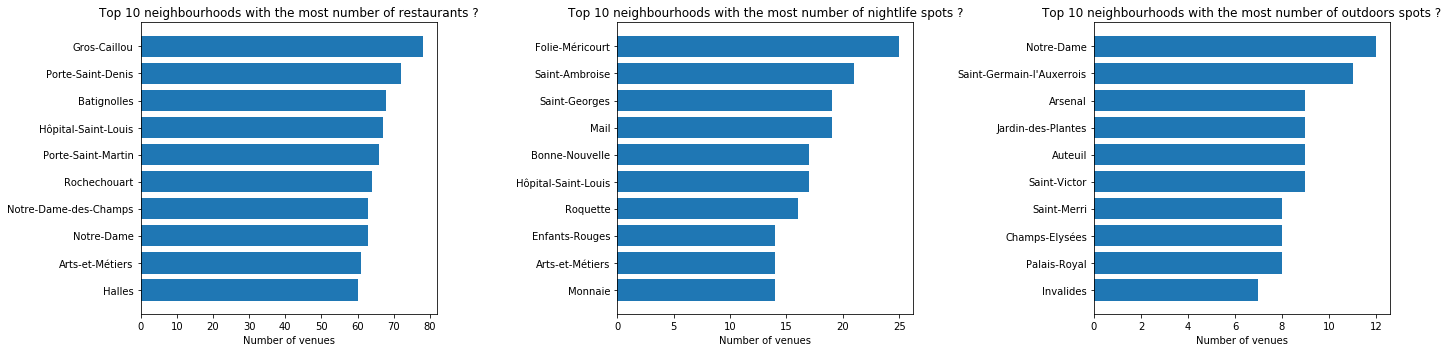

In [34]:
fig = plt.figure(figsize=(20, 5)) # create figure

ax0 = fig.add_subplot(1, 3, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 3, 2) # add subplot 2 (1 row, 2 columns, second plot)
ax2 = fig.add_subplot(1, 3, 3) # add subplot 2 (1 row, 2 columns, third plot)

# Subplot 1: Food

neighbourhoods_name = neighbourhoods_food['Neighbourhood'][0:10]
y_pos = np.arange(len(neighbourhoods_food['Neighbourhood'][0:10]))
number_of_venues = neighbourhoods_food['Food'][0:10]

ax0.barh(y_pos, number_of_venues, align='center')
ax0.set_yticks(y_pos)
ax0.set_yticklabels(neighbourhoods_name)
ax0.invert_yaxis()  # labels read top-to-bottom
ax0.set_xlabel('Number of venues')
ax0.set_title('Top 10 neighbourhoods with the most number of restaurants ?')

# Subplot 2: Nightlife spots

neighbourhoods_name = neighbourhoods_night['Neighbourhood'][0:10]
y_pos = np.arange(len(neighbourhoods_night['Neighbourhood'][0:10]))
number_of_venues = neighbourhoods_night['Nightlife Spot'][0:10]

ax1.barh(y_pos, number_of_venues, align='center')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(neighbourhoods_name)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('Number of venues')
ax1.set_title('Top 10 neighbourhoods with the most number of nightlife spots ?')

# Subplot 3: Outdoors & Recreation

neighbourhoods_name = neighbourhoods_outdoors['Neighbourhood'][0:10]
y_pos = np.arange(len(neighbourhoods_outdoors['Neighbourhood'][0:10]))
number_of_venues = neighbourhoods_outdoors['Outdoors & Recreation'][0:10]

ax2.barh(y_pos, number_of_venues, align='center')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(neighbourhoods_name)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xlabel('Number of venues')
ax2.set_title('Top 10 neighbourhoods with the most number of outdoors spots ?')

plt.tight_layout()
plt.show()

### Scatter plot of number of venues by population

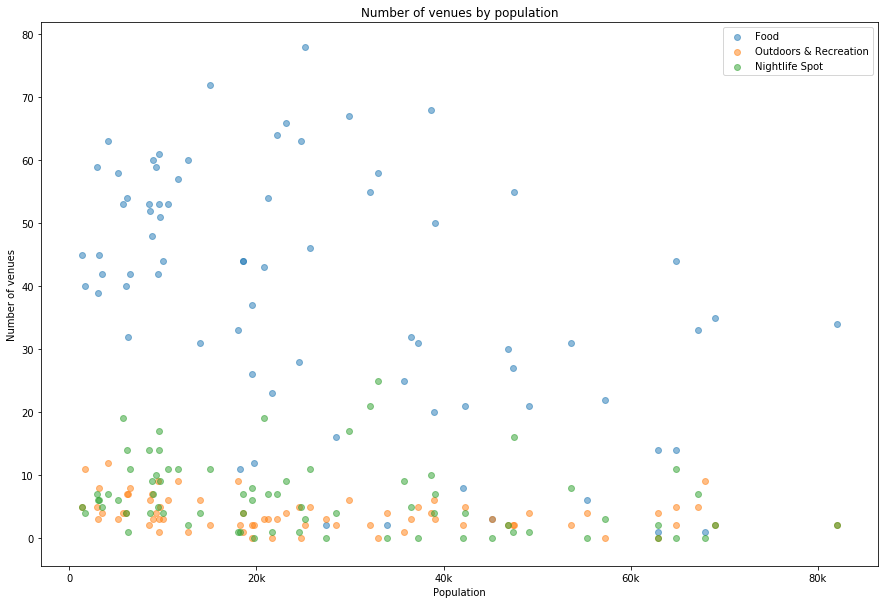

In [35]:
plt.figure(figsize=(15,10))
plt.scatter(neighbourhoods['Population'],neighbourhoods['Food'], alpha=0.5)
plt.scatter(neighbourhoods['Population'],neighbourhoods['Outdoors & Recreation'],alpha=0.5)
plt.scatter(neighbourhoods['Population'],neighbourhoods['Nightlife Spot'],alpha=0.5)
plt.xlabel('Population')
plt.ylabel('Number of venues')
plt.title('Number of venues by population')
plt.xticks(np.arange(0, 100000, 20000.0),['0', '20k', '40k', '60k', '80k'])
plt.legend()

plt.show()

### Map with Restaurants

In [36]:
# create a numpy array of length 6 and has linear spacing 
threshold_scale = np.linspace(neighbourhoods['Food'].min(),
                              neighbourhoods['Food'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

m = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.Choropleth(
    geo_data=geo_json,
    data=neighbourhoods,
    columns=['Neighbourhood', 'Food'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlGn',
    legend_name='Paris neighbourhoods',
    fill_opacity=0.7, 
    line_opacity=0.2,
    reset = True
).add_to(m)

m

### Map with Nightlife Spots

In [37]:
# create a numpy array of length 6 and has linear spacing 
threshold_scale = np.linspace(neighbourhoods['Nightlife Spot'].min(),
                              neighbourhoods['Nightlife Spot'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

m = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.Choropleth(
    geo_data=geo_json,
    data=neighbourhoods,
    columns=['Neighbourhood', 'Nightlife Spot'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlGn',
    legend_name='Paris neighbourhoods',
    fill_opacity=0.7, 
    line_opacity=0.2,
    reset = True
).add_to(m)

m

### Map with Outdoors & Recreation

In [38]:
# create a numpy array of length 6 and has linear spacing 
threshold_scale = np.linspace(neighbourhoods['Outdoors & Recreation'].min(),
                              neighbourhoods['Outdoors & Recreation'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

m = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.Choropleth(
    geo_data=geo_json,
    data=neighbourhoods,
    columns=['Neighbourhood', 'Outdoors & Recreation'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlGn',
    legend_name='Paris neighbourhoods',
    fill_opacity=0.7, 
    line_opacity=0.2,
    reset = True
).add_to(m)

m

<a id="item7"></a>

## Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [39]:
# set number of clusters
kclusters = 5

neighbourhoods_clustering = neighbourhoods.drop(['Neighbourhood','Area','Borough','Latitude','Longitude','Population'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbourhoods_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 3, 1, 2, 1, 2, 0, 3, 1], dtype=int32)

Let's create a new dataframe that includes the cluster

In [40]:
# add clustering labels
neighbourhoods.insert(0, 'Cluster Labels', kmeans.labels_)

Finally, let's visualize the resulting clusters

In [41]:
neighbourhoods.head()

,Cluster Labels,Borough,Latitude,Longitude,Neighbourhood,Young Ratio,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Total Venues,Population,Area
66,2,19,48.881638,2.395440,Amérique,0.45,0,0,6,0,4,0,2,2,14,55365.0,183.6
69,4,3,48.859192,2.363205,Archives,0.48,9,0,52,4,6,2,24,2,99,8609.0,36.8
22,3,4,48.851585,2.364768,Arsenal,0.41,6,0,42,5,9,1,6,8,77,9474.0,48.7
68,1,3,48.866470,2.357083,Arts-et-Métiers,0.48,7,0,61,14,1,0,9,6,98,9560.0,31.8
75,2,16,48.850622,2.252277,Auteuil,0.43,3,0,1,0,9,1,1,0,15,67967.0,303.0


### Map with Clusters

In [42]:
m = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.Choropleth(
    geo_data=geo_json,
    data=neighbourhoods,
    columns=['Neighbourhood', 'Cluster Labels'],
    key_on='feature.properties.name',
    threshold_scale=[0, 1, 2, 3, 4, 5],
    fill_color='YlGn',
    legend_name='Paris neighbourhoods',
    fill_opacity=0.7, 
    line_opacity=0.2,
    reset = True
).add_to(m)

m

In [43]:
df_venues = neighbourhoods

In [44]:
df_venues.drop(['Cluster Labels','Borough','Latitude','Longitude','Young Ratio','Total Venues','Population','Area'],axis=1,inplace = True)

Let's write a function to sort the venues in descending order.

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [46]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = df_venues['Neighbourhood']

for ind in np.arange(df_venues.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_venues.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
66,Amérique,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Professional & Other Places
69,Archives,Food,Shop & Service,Arts & Entertainment,Outdoors & Recreation,Nightlife Spot
22,Arsenal,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Arts & Entertainment
68,Arts-et-Métiers,Food,Nightlife Spot,Shop & Service,Arts & Entertainment,Travel & Transport
75,Auteuil,Outdoors & Recreation,Arts & Entertainment,Shop & Service,Professional & Other Places,Food


Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [47]:
neighbourhoods = pd.merge(neighbourhoods, neighborhoods_venues_sorted, how='left', on=['Neighbourhood'])
neighbourhoods.head()

,Neighbourhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Amérique,0,0,6,0,4,0,2,2,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Professional & Other Places
1,Archives,9,0,52,4,6,2,24,2,Food,Shop & Service,Arts & Entertainment,Outdoors & Recreation,Nightlife Spot
2,Arsenal,6,0,42,5,9,1,6,8,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Arts & Entertainment
3,Arts-et-Métiers,7,0,61,14,1,0,9,6,Food,Nightlife Spot,Shop & Service,Arts & Entertainment,Travel & Transport
4,Auteuil,3,0,1,0,9,1,1,0,Outdoors & Recreation,Arts & Entertainment,Shop & Service,Professional & Other Places,Food


## Check Results

### Map with Young Ratio

In [ ]:
m = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.Choropleth(
    geo_data=geo_json,
    data=neighbourhoods,
    columns=['Neighbourhood', 'Young Ratio'],
    key_on='feature.properties.name',
    #threshold_scale=[0, 1, 2, 3, 4, 5],
    fill_color='YlGn',
    legend_name='Paris neighbourhoods',
    fill_opacity=0.7, 
    line_opacity=0.2,
    reset = True
).add_to(m)

m